# Dogs vs. Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [244]:
import numpy as np
import keras
from keras.models import Model
# from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image as ker_img

In [245]:
# IMG_SIZE = (224, 224)  # размер входного изображения сети VGG16
IMG_SIZE = (299, 299)  # размер входного изображения сети InceptionV3

VAL_SIZE = 100  # число изображений в валидационной выборке
BATCH_SIZE = 100
N_EPOCHS = 5

## Функции загрузки данных

In [246]:
import re
from random import shuffle
from glob import glob
import cv2

train_files = glob('./train/*.jpg')
test_files = glob('./test1/*.jpg')

def load_vanilla_image(path, target_size=IMG_SIZE):
# функция загрузки и масштабирования входного изображения
    img = cv2.resize(cv2.imread(path),
                      IMG_SIZE,
                      interpolation=cv2.INTER_AREA)[...,::-1]
#     return preprocess_input(img, mode='tf')
    return preprocess_input(img)

# Аугментатор изображений
augmenter = ker_img.ImageDataGenerator(rotation_range=45., horizontal_flip=True, zoom_range=0.2)

def load_augmented_image(path, target_size=IMG_SIZE):
# функция загрузки, аугментации и масштабирования входного изображения
    img = cv2.imread(path)
    img = augmenter.apply_transform(img, augmenter.get_random_transform(img.shape))
    img = cv2.resize(img,
                     IMG_SIZE,
                     interpolation=cv2.INTER_AREA)[...,::-1]
#     return preprocess_input(img, mode='tf')
    return preprocess_input(img)

def augmented_generator(files, batch_size=32):
# генератор для последовательного чтения обучающих данных с диска
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_augmented_image(path) for path in files[i:j]])
            y = np.array([1. if re.match('.*/dog\.\d', path) else 0. for path in files[i:j]])
            yield (x, y)

def vanilla_generator(files, batch_size=32):
# генератор для последовательного чтения неискаженных размеченных данных с диска
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_vanilla_image(path) for path in files[i:j]])
            y = np.array([1. if re.match('.*/dog\.\d', path) else 0. for path in files[i:j]])
            yield (x, y)
            
# генератор последовательного чтения неразмеченных данных с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_vanilla_image(path)])

## Визуализируем примеры для обучения

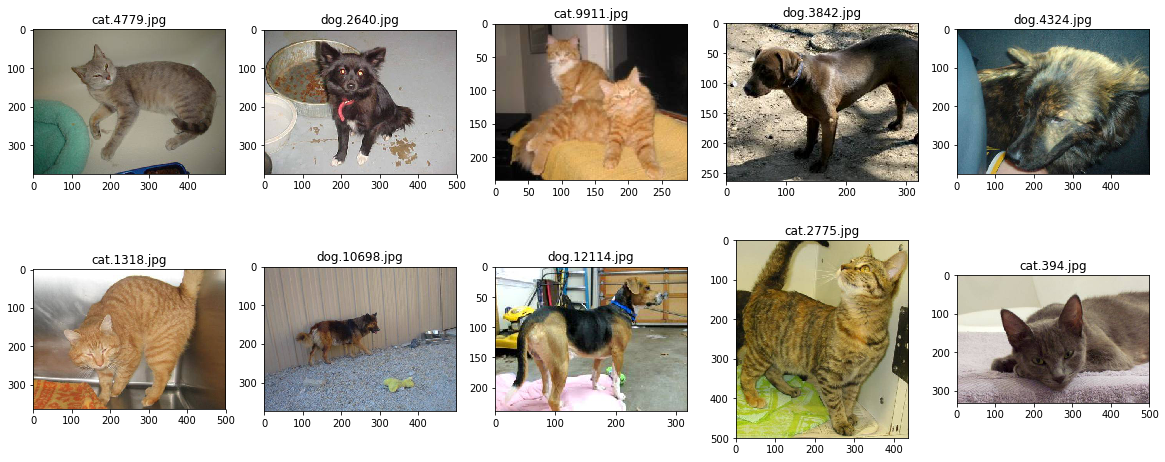

In [247]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%s' % path.split('/')[-1]);

## Загружаем предобученную модель

In [248]:
# base_model -  объект класса keras.models.Model (Functional Model)

# Загрузка предобученной модели InceptionV3, веса тянутся по сети с GitHub:
# base_model = VGG16(include_top = True,
#                    weights = 'imagenet',
#                    input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))
# base_model.save('VGG16_imagenet.h5')

# Загрузка предобученной модели InceptionV3, веса тянутся по сети с GitHub:
# base_model = InceptionV3(include_top = True,
#                          weights = 'imagenet',
#                          input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))
# base_model.save('InceptionV3_imagenet.h5')

# Загрузка готовой модели из файла:
# base_model = keras.models.load_model('VFF16_imagenet.h5')
base_model = keras.models.load_model('InceptionV3_imagenet.h5')

/home/pushchinav/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [249]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

In [250]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

## Добавляем полносвязный слой

In [251]:
x = base_model.layers[-2].output
# x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1,  # один выход
                activation='sigmoid',  # функция активации  
                kernel_regularizer=keras.regularizers.l1_l2(1e-4))(x)
model = Model(inputs=base_model.input, outputs=x)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

## Компилируем модель и запускаем обучение

In [252]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [274]:
shuffle(train_files)  # перемешиваем обучающую выборку

# запускаем процесс обучения
model.fit_generator(# данные читаем функцией-генератором
                    augmented_generator(train_files[VAL_SIZE:], BATCH_SIZE),
                    # число вызовов генератора за эпоху
                    steps_per_epoch=len(train_files[VAL_SIZE:]) // BATCH_SIZE,
                    epochs=N_EPOCHS,
                    validation_data=vanilla_generator(train_files[:VAL_SIZE], VAL_SIZE),
                    validation_steps=1)

Epoch 1/1
249/249 [==============================] - 699s 3s/step - loss: 0.1584 - acc: 0.9634 - val_loss: 0.1106 - val_acc: 0.9700


In [275]:
model.save('InceptionV3_imagenet_full_CvsD.h5')

## Предсказания на проверочной выборке

In [276]:
pred = model.predict_generator(predict_generator(test_files),
                               len(test_files),
                               max_queue_size=500)

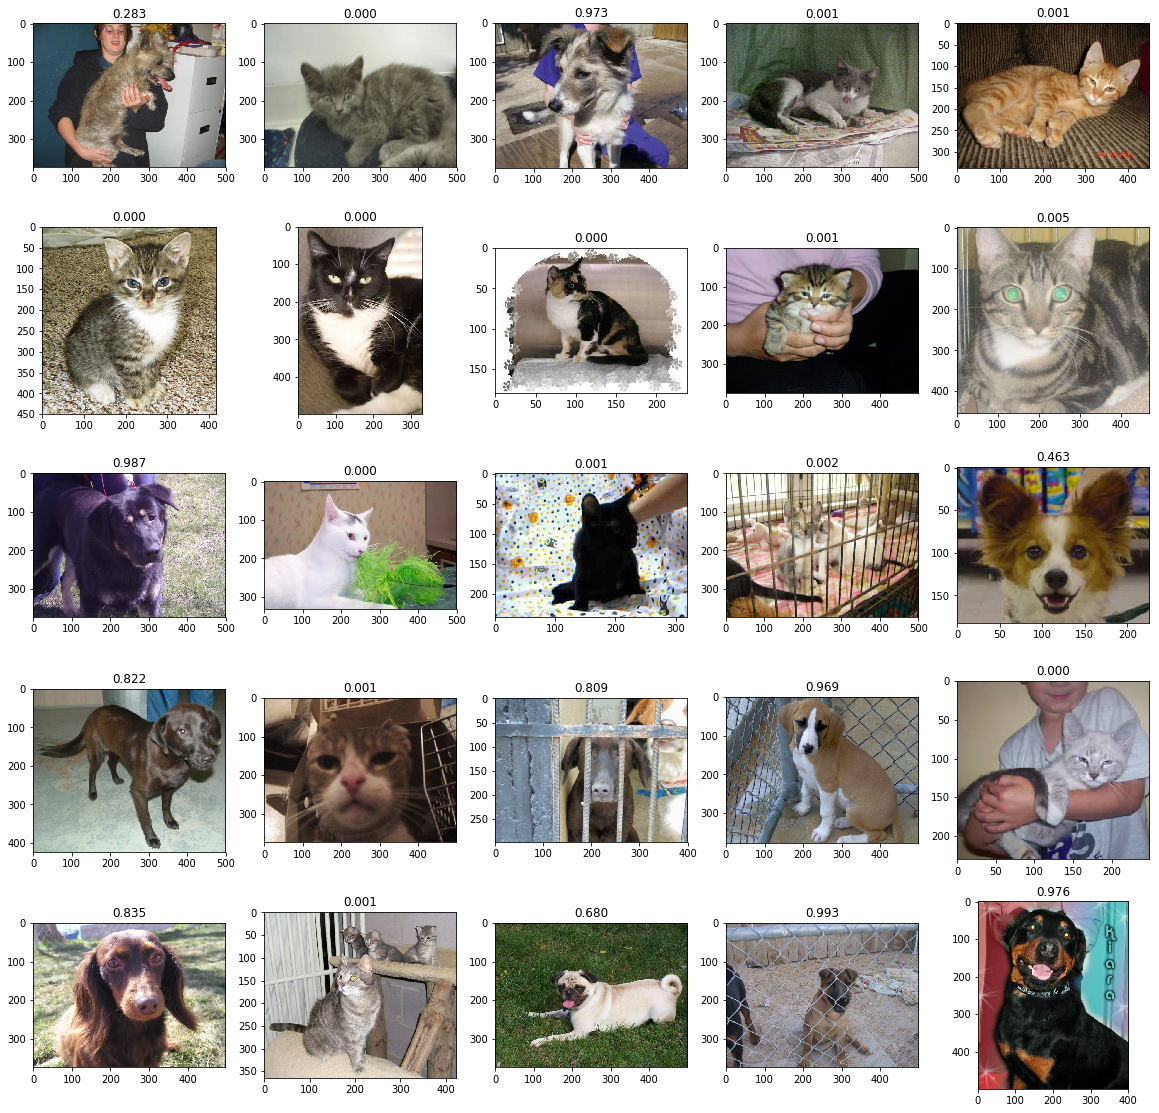

In [277]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, (path, score) in enumerate(zip(test_files[80:][:25], pred[80:][:25]), 1):
    subplot = fig.add_subplot(5, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%.3f' % score);

## Выводим наиболее непонятные из картинок

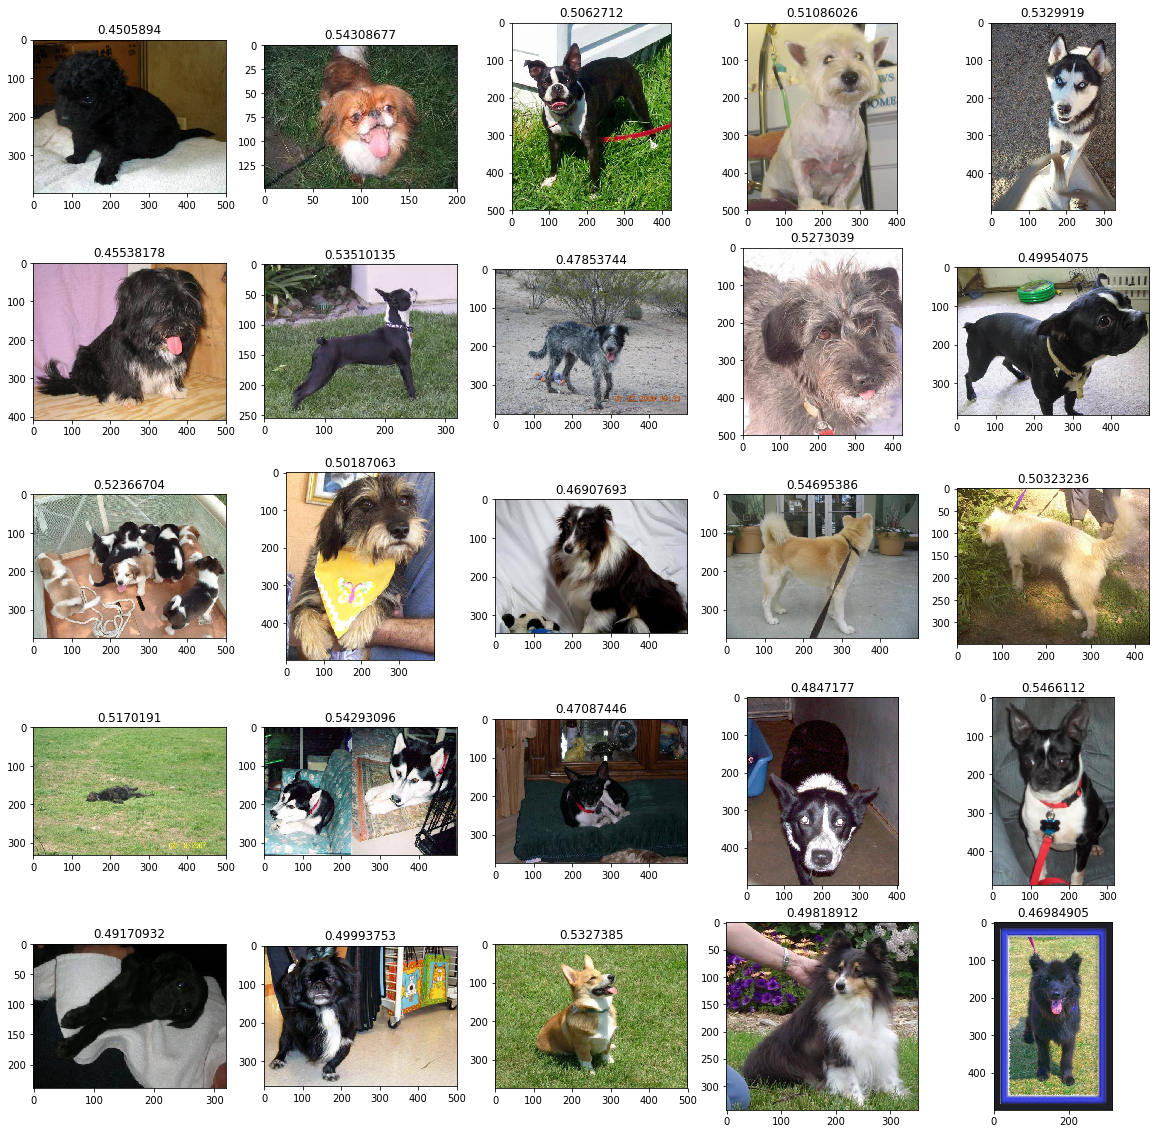

In [278]:
str2float = np.vectorize(lambda x: float(x))
test_files_strange = np.stack((pred[:,0], np.array(test_files)), axis=1)
test_files_strange = test_files_strange[str2float(test_files_strange[:,0]) < 0.55]
test_files_strange = test_files_strange[str2float(test_files_strange[:,0]) > 0.45]
fig = plt.figure(figsize=(20, 20))
for i, (score, path) in enumerate(test_files_strange[-25:,:] ,1):
    subplot = fig.add_subplot(5, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title(score);

## Готовим данные для сабмита

In [279]:
# Сортируем по именам файлов
index = list(np.argsort([int(re.search('(\d+\.)', i).group(1)[:-1]) for i in test_files]))
submit = np.stack((np.array(test_files), pred[:,0]), axis=1)[index]

with open('submit.csv', 'w') as dst:
    dst.write('id,label\n')
    for (path, score) in submit:
        dst.write('%s,%f\n' % (re.search('(\d+\.)', path).group(0)[:-1], float(score)))
        
from scipy.stats.mstats import winsorize
submit_windorised = np.stack((np.array(test_files),
                              winsorize(pred[:,0], limits = 0.1)), axis=1)[index]
with open('submit_winsorised.csv', 'w') as dst:
    dst.write('id,label\n')
    for (path, score) in submit_windorised:
        dst.write('%s,%f\n' % (re.search('(\d+\.)', path).group(0)[:-1], float(score)))

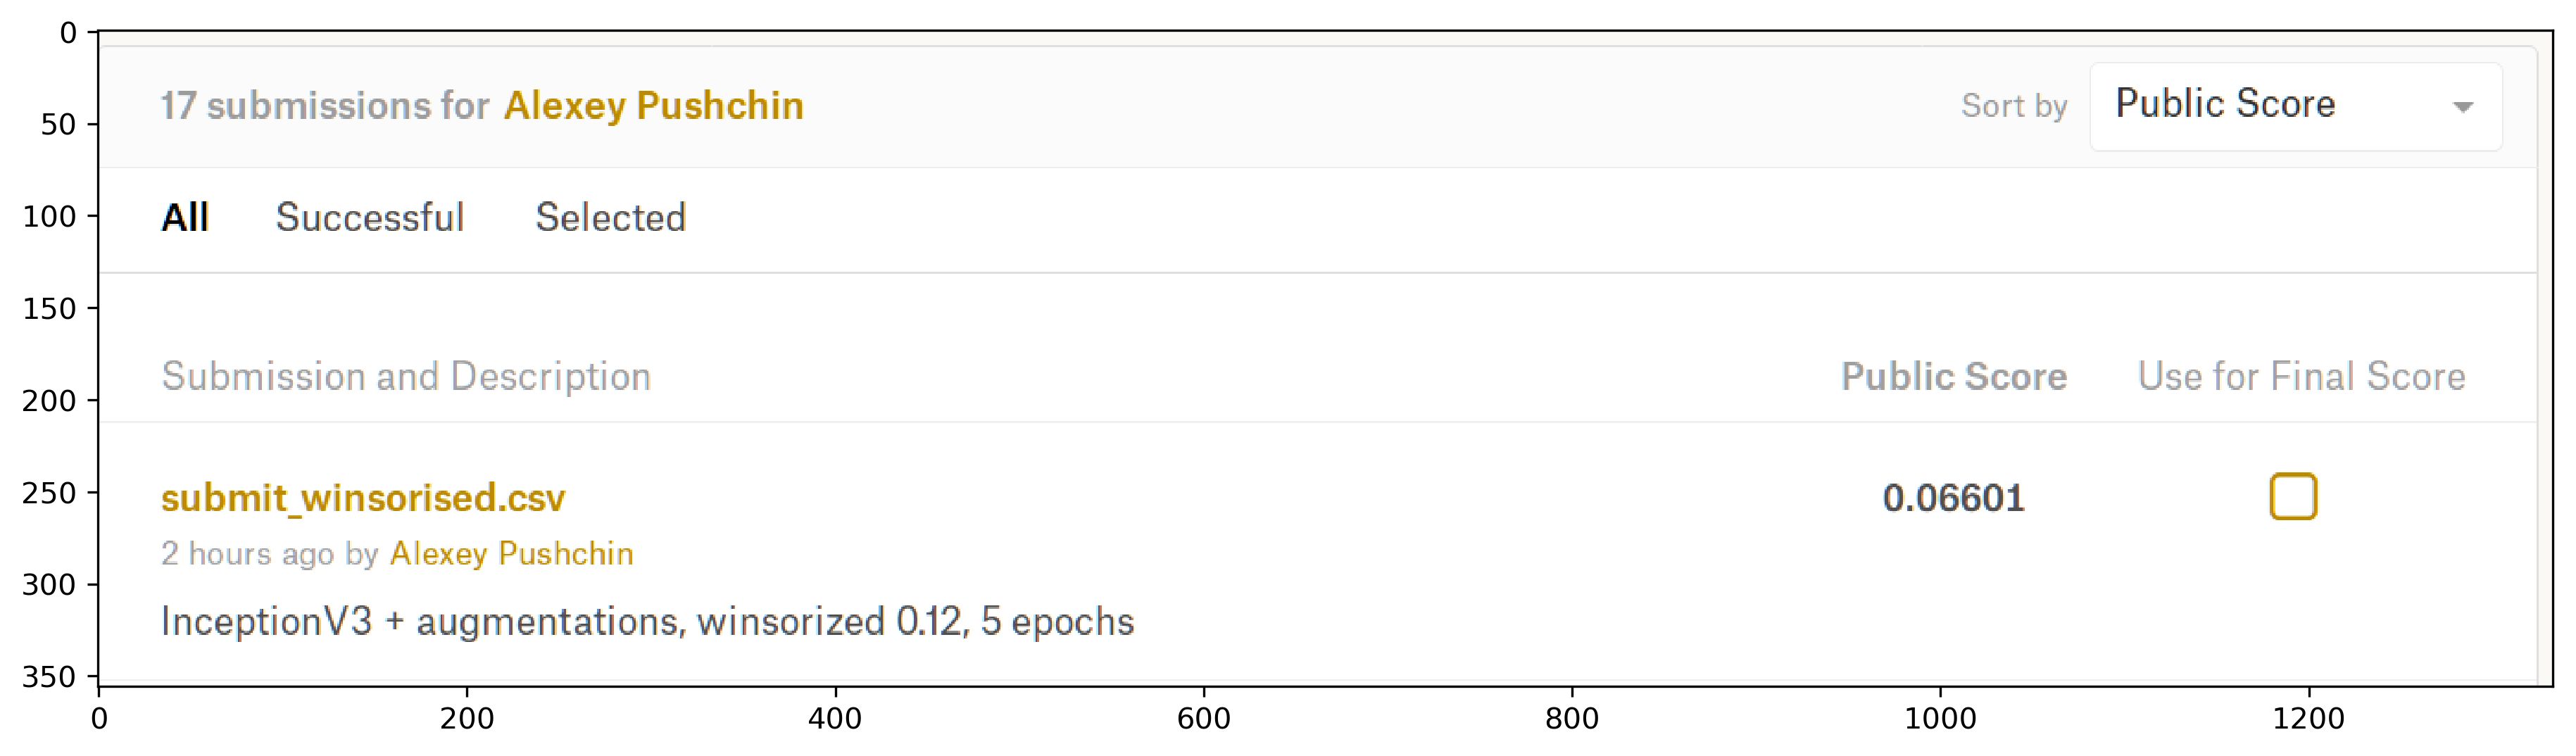

In [285]:
# LogLoss = 0.06601

plt.figure(figsize=(15,6), dpi=300)
plt.imshow(cv2.imread('Score.png'));